In [1]:
import sys
sys.executable

'/usr/local/opt/python@3.9/bin/python3.9'

In [2]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

# Part 1 - Segmentation

In [3]:
image_path = 'segmentation/call.png'

In [4]:
# img = cv2.imread('segmentation/call.png')
# gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# plt.imshow(gray);
# _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
# plt.imshow(thresh);

In [5]:
def process_image(image_path):
    # 01 - Load the image
    img = cv2.imread(image_path)
    # 02 - Convert the image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # numpy.ndarray, (257, 522)
    # 03 - Apply thresholding to convert the image to binary
    _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    # 04 - Perform connected component analysis to separate the characters
    connected_components_output = cv2.connectedComponentsWithStats(thresh, connectivity=8)
    # 05 - Extract characters
    chars = _process_characters(connected_components_output)
    return chars

In [6]:
def _process_characters(connected_components_output):
    num_labels, labels, stats, centroids = connected_components_output
    # Get the number of characters (excluding the background)
    num_chars = num_labels - 1
    # Define a list to store individual characters
    chars = []
    # Define a list to store the coordinates of each character
    coords = []
    # Loop through each character
    for i in range(num_chars):
        # Extract the character by cropping the image
        char = labels == i + 1
        char = char.astype(np.uint8) * 255

        # Store the character and its coordinates
        chars.append(char)
        coords.append(stats[i+1][:2])
    # Sort the characters based on their x-coordinates (from right to left)
    chars = [char for _, char in sorted(zip(coords, chars), key=lambda x: x[0][0], reverse=True)]
    assert len(chars) == num_chars
    return chars

In [7]:
chars = process_image('segmentation/call.png')

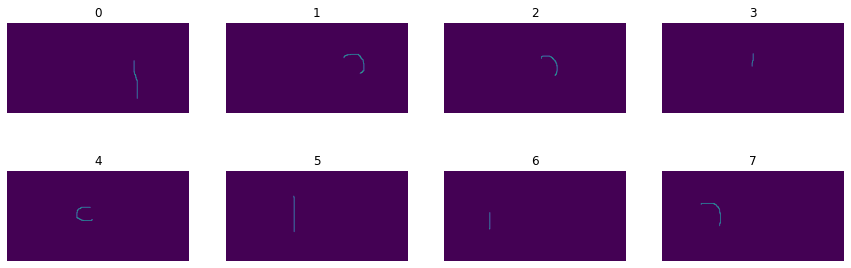

In [8]:
fig, axes = plt.subplots(2, len(chars)//2, sharex=True, sharey=True, figsize=(15, 5))

for (i, img), ax in zip(enumerate(chars), axes.flat):
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(i)

# Part 2 - Classification

In [9]:
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
# from keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import load_img
from tensorflow.keras.utils import img_to_array
from keras.models import Sequential
from keras.applications.vgg19 import VGG19
from keras.layers import Dense, Flatten
from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import LabelEncoder
# from PIL import Image
# from keras.models import load_model
# from keras.preprocessing import image
import numpy as np

2023-05-23 08:47:13.080309: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [24]:
# prepare a list of image files to be loaded
def image_files(input_directory):
    filepaths = []
    labels = []

    digit_folders = os.listdir(input_directory)
    # print(digit_folders)

    for digit in digit_folders:
        path = os.path.join(input_directory, digit)
        flist = os.listdir(path)
        for f in flist:
            fpath = os.path.join(path, f)
            filepaths.append(fpath)
            labels.append(digit)
    return filepaths, labels


def load_images(filepaths):
    images = []
    for i in tqdm(range(len(filepaths))):
        img = load_img(filepaths[i], target_size=(32, 32, 3), grayscale=False)
        img = img_to_array(img)
        img.astype('float32')
        img = img / 255
        images.append(img)

    images = np.array(images)
    return images

In [28]:
# load the paths and labels in differnt variables
directory_10k = r'/Users/stav/Projects/CodeSH/vgg_for_final_project/TRAIN'
filepaths, labels = image_files(directory_10k) # 5,099 files

In [29]:
len(filepaths)

5099

In [30]:
# load the 10K images
images = load_images(filepaths)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 5099/5099 [00:04<00:00, 1250.32it/s]


In [31]:
y = to_categorical(labels, num_classes=28)
X_train, X_test, y_train, y_test = train_test_split(images, y, random_state=42, test_size=0.2)

In [32]:
print(X_train.shape)
print(X_test.shape)

(4079, 32, 32, 3)
(1020, 32, 32, 3)


In [33]:
vgg19 = VGG19(weights='imagenet',
              include_top=False,
              input_shape=(32, 32, 3)
              )

2023-05-23 08:50:51.899173: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [34]:
vgg19

In [35]:
model = Sequential()
model.add(vgg19)
model.add(Flatten())
model.add(Dense(28, activation='softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

In [37]:
model.layers

In [39]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 1, 1, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 28)                14364     
                                                                 
Total params: 20,038,748
Trainable params: 20,038,748
Non-trainable params: 0
_________________________________________________________________


In [40]:
EPOCHS = 5
history = model.fit(X_train, y_train,
                    epochs=EPOCHS,
                    batch_size=128,
                    validation_data=(X_test, y_test)
                    )

Epoch 1/5
32/32 [==============================] - 85s 3s/step - loss: 3.0214 - accuracy: 0.1797 - val_loss: 2.7893 - val_accuracy: 0.2157
Epoch 2/5
32/32 [==============================] - 86s 3s/step - loss: 1.8940 - accuracy: 0.4663 - val_loss: 1.1105 - val_accuracy: 0.6784
Epoch 3/5
32/32 [==============================] - 84s 3s/step - loss: 0.8774 - accuracy: 0.7438 - val_loss: 0.8436 - val_accuracy: 0.7716
Epoch 4/5
32/32 [==============================] - 99s 3s/step - loss: 0.7048 - accuracy: 0.7980 - val_loss: 0.8147 - val_accuracy: 0.7529
Epoch 5/5
32/32 [==============================] - 103s 3s/step - loss: 0.5880 - accuracy: 0.8208 - val_loss: 0.8722 - val_accuracy: 0.7441


In [48]:
model

In [ ]:
model(

In [50]:
y_test.shape

(1020, 28)

In [51]:
y_test[2]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [52]:
y_test[20]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [82]:
for img_idx in range(100):
    prob = model.predict(X_test[img_idx].reshape(1, 32, 32, 3))
    y_pred   = np.argmax(prob)            # softmax output
    y_actual = np.argmax(y_test[img_idx]) # one-hot encoding
    if y_pred != y_actual:
        print('Error for index:', img_idx)

1/1 [==============================] - 0s 51ms/step
Error for index: 0
1/1 [==============================] - 0s 37ms/step
Error for index: 2
1/1 [==============================] - 0s 42ms/step
Error for index: 4
1/1 [==============================] - 0s 34ms/step
Error for index: 5
1/1 [==============================] - 0s 40ms/step
Error for index: 10
1/1 [==============================] - 0s 38ms/step
Error for index: 11
1/1 [==============================] - 0s 33ms/step
Error for index: 21
1/1 [==============================] - 0s 37ms/step
Error for index: 23
1/1 [==============================] - 0s 34ms/step
Error for index: 25
1/1 [==============================] - 0s 35ms/step
Error for index: 31
1/1 [==============================] - 0s 33ms/step
Error for index: 35
1/1 [==============================] - 0s 40ms/step
Error for index: 38
1/1 [==============================] - 0s 35ms/step
Error for index: 39
1/1 [==============================] - 0s 33ms/step
Error for index:

In [83]:
img_idx = 79
prob = model.predict(X_test[img_idx].reshape(1, 32, 32, 3))
y_pred   = np.argmax(prob)            # softmax output
y_actual = np.argmax(y_test[img_idx]) # one-hot encoding

1/1 [==============================] - 0s 39ms/step


In [85]:
y_pred, y_actual

(26, 14)

In [109]:
prob

array([[5.2701775e-04, 1.7752871e-04, 7.4542462e-05, 1.2391385e-04,
        4.4470813e-05, 5.2801561e-06, 1.2626484e-04, 1.3309697e-04,
        3.8806818e-05, 3.7252287e-06, 3.0750962e-05, 2.5051946e-04,
        3.1568683e-03, 4.0978044e-05, 1.7307270e-02, 3.9947601e-03,
        1.6768216e-04, 1.7573951e-05, 6.6044577e-04, 1.6924777e-04,
        1.8496968e-02, 1.0224337e-03, 1.4309661e-01, 2.4420233e-04,
        5.5946282e-05, 1.0446213e-04, 8.0987108e-01, 5.7500467e-05]],
      dtype=float32)

In [108]:
for i, p in enumerate(prob[0]):
    print(f'{i:02}.  {p:.6f}')

00.  0.000527
01.  0.000178
02.  0.000075
03.  0.000124
04.  0.000044
05.  0.000005
06.  0.000126
07.  0.000133
08.  0.000039
09.  0.000004
10.  0.000031
11.  0.000251
12.  0.003157
13.  0.000041
14.  0.017307
15.  0.003995
16.  0.000168
17.  0.000018
18.  0.000660
19.  0.000169
20.  0.018497
21.  0.001022
22.  0.143097
23.  0.000244
24.  0.000056
25.  0.000104
26.  0.809871
27.  0.000058


In [92]:
import seaborn as sns

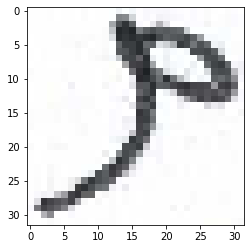

In [87]:
plt.imshow(X_test[img_idx]);

In [67]:
np.argmax(prob)

25

In [69]:
y_test[120]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.], dtype=float32)

In [70]:
np.argmax(y_test[120])

25

In [43]:
score = model.evaluate(X_test, y_test)

32/32 [==============================] - 3s 81ms/step - loss: 0.8722 - accuracy: 0.7441


In [47]:
score

[0.8721778988838196, 0.7441176176071167]

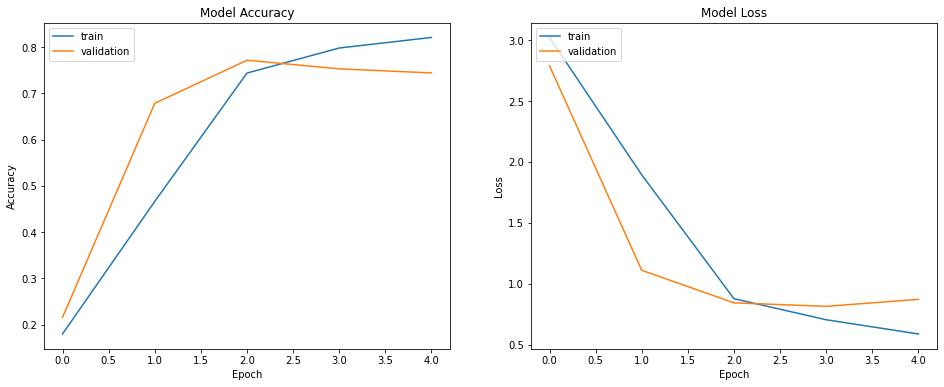

In [46]:
ig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

axes[0].plot(history.history['accuracy'])
axes[0].plot(history.history['val_accuracy'])
axes[0].set_title('Model Accuracy')
axes[0].set_ylabel('Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].legend(['train', 'validation'], loc='upper left')

axes[1].plot(history.history['loss'])
axes[1].plot(history.history['val_loss'])
axes[1].set_title('Model Loss')
axes[1].set_ylabel('Loss')
axes[1].set_xlabel('Epoch')
axes[1].legend(['train', 'validation'], loc='upper left')

plt.show()
